In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

from utils import get_financial_data

# Load financial data

In [2]:
df = get_financial_data()
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Daily Return,Lagged Return,Log Return,SMA 14,ATR 14
Date,,,,,,,,,,
2015-01-02,24.320435,24.789804,23.879983,24.778681,212818400,-0.018494,-0.019019,-0.009558,24.726403,0.556602
2015-01-05,23.635290,24.169170,23.448433,24.089088,257142000,-0.018838,-0.009513,-0.028576,24.671108,0.582501
2015-01-06,23.637505,23.897770,23.274910,23.699790,263188400,-0.002628,-0.028172,0.000094,24.639806,0.543573
2015-01-07,23.968962,24.069063,23.735389,23.846614,160423600,0.005131,0.000094,0.013925,24.655695,0.512430
2015-01-08,24.889904,24.947741,24.180289,24.298189,237458000,0.024352,0.014023,0.037703,24.695100,0.533245


# Converting Pandas DataFrame to NumPy ndarray

In [3]:
X = df.to_numpy()
X.shape

(2596, 10)

# Split and scale

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Train: {X_train_scaled.shape}, Test: {X_test_scaled.shape}')

Train: (2076, 10), Test: (520, 10)


# Create sequences

In [5]:
from utils import create_sequence

X_train_seq, y_train_seq = create_sequence(X_train_scaled, input_seq_len=10)
X_test_seq, y_test_seq = create_sequence(X_test_scaled, input_seq_len=7)

print(f'X_train, y_train: {X_train_seq.shape} {y_train_seq.shape}')
print(f'X_test, y_test: {X_test_seq.shape} {y_test_seq.shape}')

X_train, y_train: (2065, 10, 10) (2065, 10)
X_test, y_test: (512, 7, 10) (512, 10)


# Data preparation

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Convert ndarray to torch Tensor
X_train_seq, X_test_seq, y_train_seq, y_test_seq = torch.Tensor(X_train_seq), torch.Tensor(X_test_seq), torch.Tensor(y_train_seq), torch.Tensor(y_test_seq)
# Put tensors to available device
X_train_seq, X_test_seq, y_train_seq, y_test_seq = X_train_seq.to(device), X_test_seq.to(device), y_train_seq.to(device), y_test_seq.to(device)

# Add sequence dimension (Transformer needs both input and output to be sequences) [(batch_size, n_features) -> (batch_size, 1, n_features)]
y_train_seq, y_test_seq = y_train_seq.unsqueeze(1), y_test_seq.unsqueeze(1)

In [7]:
from utils import StockDataset

batch_size = 128

dataset_train = StockDataset(X_train_seq, y_train_seq)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

dataset_test = StockDataset(X_test_seq, y_test_seq)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Model definition

In [8]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, num_heads, num_layers=6, dim_ff=2048, dropout=0.1):
        super(TransformerModel, self).__init__()
        
        self.transformer = nn.Transformer(
            d_model=input_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_ff, 
            dropout=dropout,
            batch_first=True
        )
        
        self.fc_out = nn.Linear(input_dim, output_dim)

    def forward(self, src, tgt):
        output = self.transformer(src, tgt)
        output = self.fc_out(output)
        return output

In [9]:
n_features = 10
num_layers = 3
num_heads = 5
dropout = 0.3

model = TransformerModel(input_dim=n_features, output_dim=n_features, num_heads=num_heads, dropout=dropout, num_layers=num_layers)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

d:\Grgo\Programs\Python_venv\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


# Model training

In [10]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

#writer = SummaryWriter('logs')
epochs = 200
train_per_epoch = int(len(dataset_train) / batch_size)

model.train()

for epoch in range(epochs+1):

    #loop = tqdm(enumerate(dataloader_train), total=len(dataloader_train), leave=True)
    epoch_loss = 0

    for (data, target) in dataloader_train:
        output = model(data, target)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        #writer.add_scalar('loss', loss.item(), (epoch * train_per_epoch) + idx)
        #loop.set_description(f"Epoch {epoch}/{epochs}")
        #loop.set_postfix(loss=loss.item())
    
    if (epoch) % 10 == 0:
        print(f"Epoch {epoch}/{epochs} Avg Loss: {epoch_loss / len(dataloader_train):.4f}")
        #loop.write(f"Epoch {epoch}/{epochs} Avg Loss: {epoch_loss / len(dataloader_train):.4f}")

Epoch 0/200 Avg Loss: 1.2923
Epoch 10/200 Avg Loss: 0.4884
Epoch 20/200 Avg Loss: 0.3317
Epoch 30/200 Avg Loss: 0.2753
Epoch 40/200 Avg Loss: 0.2686
Epoch 50/200 Avg Loss: 0.2235
Epoch 60/200 Avg Loss: 0.1882
Epoch 70/200 Avg Loss: 0.1716
Epoch 80/200 Avg Loss: 0.1627
Epoch 90/200 Avg Loss: 0.1355
Epoch 100/200 Avg Loss: 0.1289
Epoch 110/200 Avg Loss: 0.1177
Epoch 120/200 Avg Loss: 0.1233
Epoch 130/200 Avg Loss: 0.1015
Epoch 140/200 Avg Loss: 0.0935
Epoch 150/200 Avg Loss: 0.0834
Epoch 160/200 Avg Loss: 0.0909
Epoch 170/200 Avg Loss: 0.0835
Epoch 180/200 Avg Loss: 0.0862
Epoch 190/200 Avg Loss: 0.0791
Epoch 200/200 Avg Loss: 0.0749


# Model evaluation

In [11]:
model.eval()

with torch.no_grad():

    val_output = model(X_test_seq, y_test_seq)
    val_loss = criterion(val_output, y_test_seq)
    print(f"Validation Loss: {val_loss.item()}")

Validation Loss: 0.5891543626785278


# Plot train results

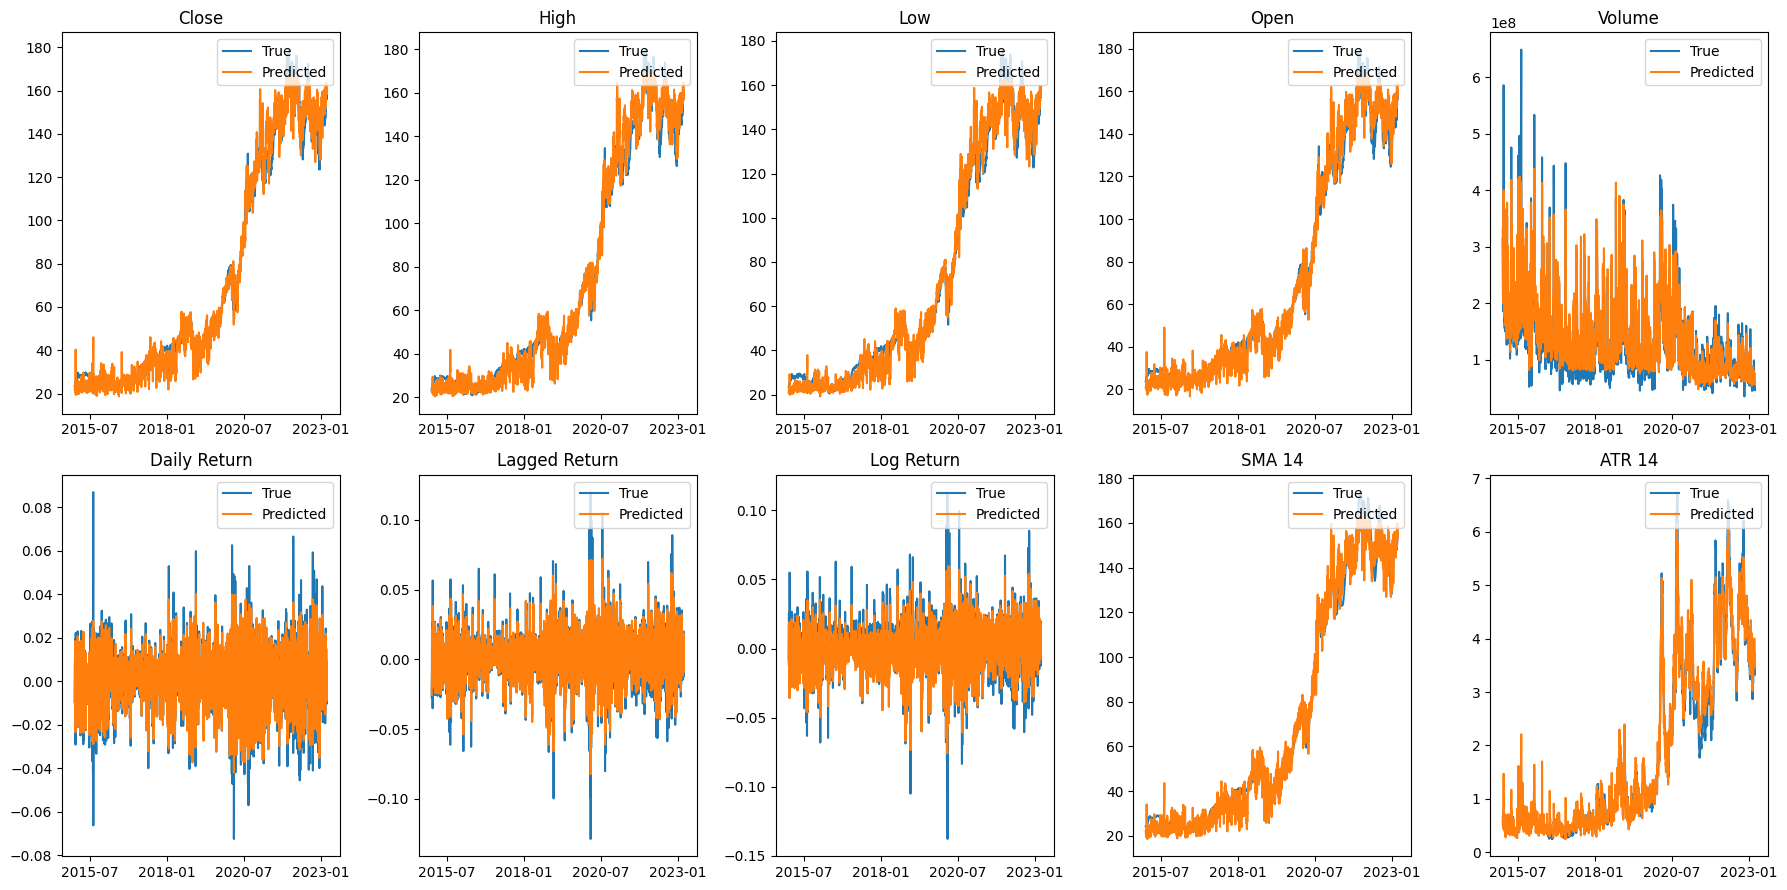

In [14]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(2, 5, figsize=(18, 9))
axes = axes.flatten()

y_true = scaler.inverse_transform(y_train_seq.squeeze(1).cpu().detach().numpy())
y_pred = model(X_train_seq, y_train_seq).squeeze(1).cpu().detach().numpy()
y_pred = scaler.inverse_transform(y_pred)

train_dates = df.index[:len(X_train_seq)]

for idx, c in enumerate(df.columns):
    axes[idx].plot(train_dates, y_true[:, idx], color='#1f77b4', label='True')
    axes[idx].plot(train_dates, y_pred[:, idx], color='#ff7f0e', label='Predicted')
    axes[idx].set_title(c)
    axes[idx].legend(loc='upper right')
    axes[idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[idx].xaxis.set_major_locator(mdates.MonthLocator(interval=30))

plt.tight_layout()
plt.show()

# Plotting test results

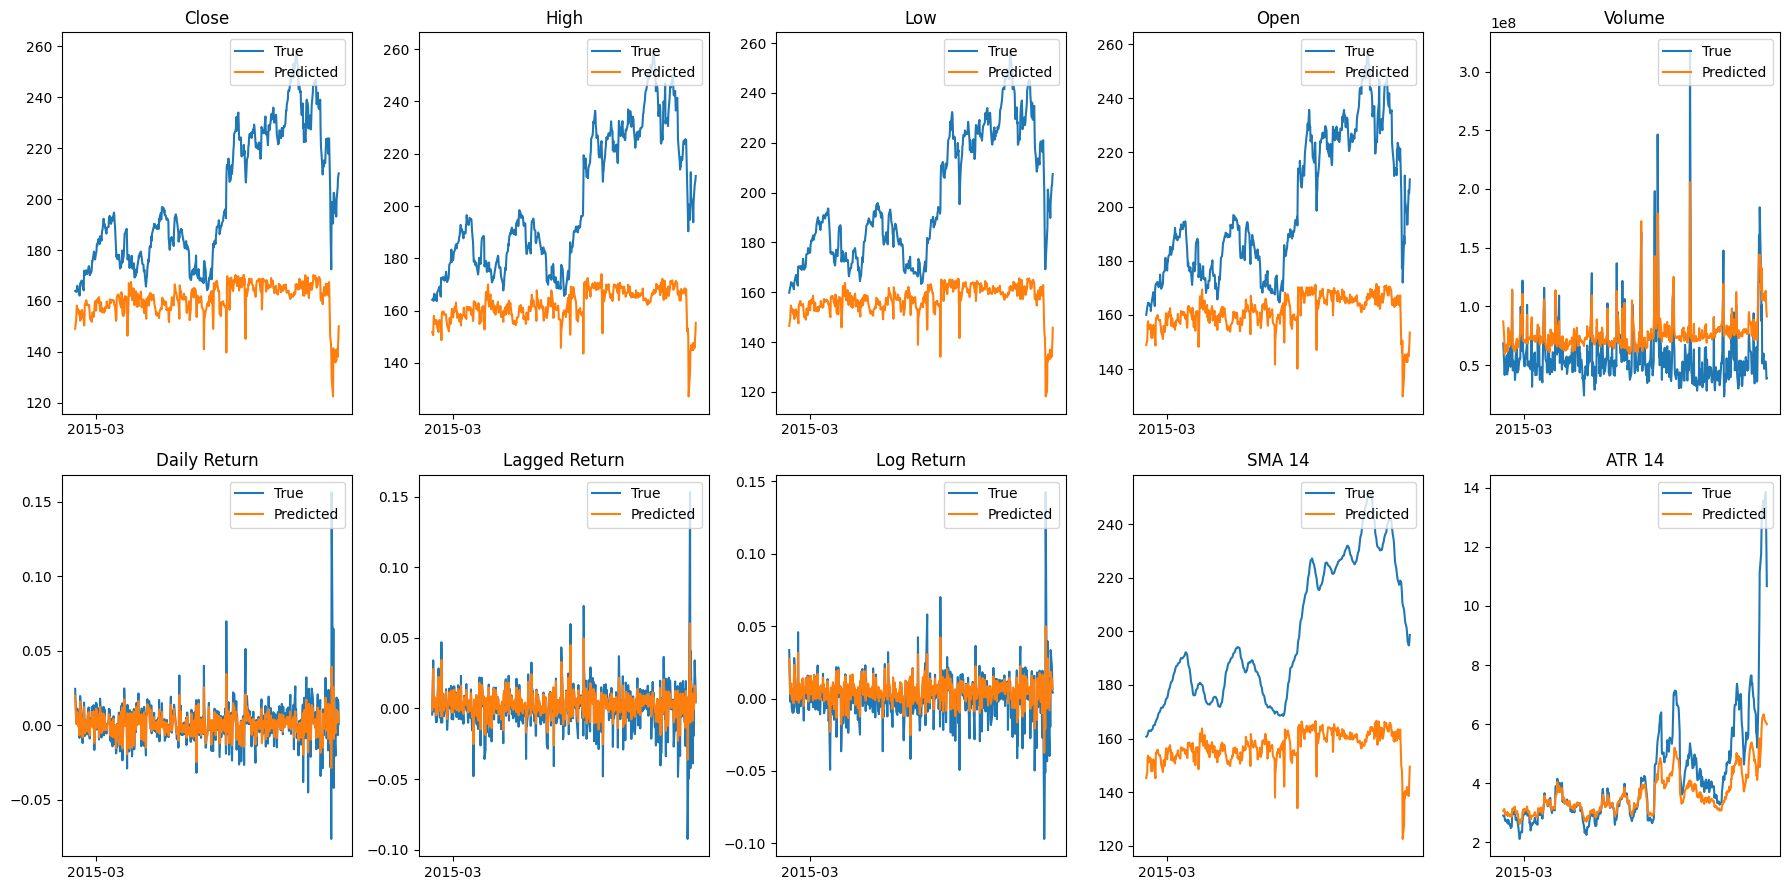

In [15]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(2, 5, figsize=(18, 9))
axes = axes.flatten()

y_true = scaler.inverse_transform(y_test_seq.squeeze(1).cpu().detach().numpy())
y_pred = model(X_test_seq, y_test_seq).squeeze(1).cpu().detach().numpy()
y_pred = scaler.inverse_transform(y_pred)

test_dates = df.index[:len(X_test_seq)]

for idx, c in enumerate(df.columns):
    axes[idx].plot(test_dates, y_true[:, idx], color='#1f77b4', label='True')
    axes[idx].plot(test_dates, y_pred[:, idx], color='#ff7f0e', label='Predicted')
    axes[idx].set_title(c)
    axes[idx].legend(loc='upper right')
    axes[idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[idx].xaxis.set_major_locator(mdates.MonthLocator(interval=30))

plt.tight_layout()
plt.show()

# Create sequences

- many-to-many

In [16]:
X_train_seq, y_train_seq = create_sequence(X_train_scaled, input_seq_len=10, target_seq_len=10)
X_test_seq, y_test_seq = create_sequence(X_test_scaled, input_seq_len=7, target_seq_len=7)

print(f'X_train, y_train: {X_train_seq.shape} {y_train_seq.shape}')
print(f'X_test, y_test: {X_test_seq.shape} {y_test_seq.shape}')

X_train, y_train: (2056, 10, 10) (2056, 10, 10)
X_test, y_test: (506, 7, 10) (506, 7, 10)


In [17]:
X_train_seq, X_test_seq, y_train_seq, y_test_seq = torch.Tensor(X_train_seq), torch.Tensor(X_test_seq), torch.Tensor(y_train_seq), torch.Tensor(y_test_seq)

X_train_seq, X_test_seq, y_train_seq, y_test_seq = X_train_seq.to(device), X_test_seq.to(device), y_train_seq.to(device), y_test_seq.to(device)

In [18]:
batch_size = 128

dataset_train = StockDataset(X_train_seq, y_train_seq)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

dataset_test = StockDataset(X_test_seq, y_test_seq)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [19]:
n_features = 10
num_layers = 3
num_heads = 5
dropout = 0.3

model = TransformerModel(input_dim=n_features, output_dim=n_features, num_heads=num_heads, dropout=dropout, num_layers=num_layers)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

d:\Grgo\Programs\Python_venv\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


In [21]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

#writer = SummaryWriter('logs')
epochs = 200
train_per_epoch = int(len(dataset_train) / batch_size)

model.train()

for epoch in range(epochs+1):

    #loop = tqdm(enumerate(dataloader_train), total=len(dataloader_train), leave=True)
    epoch_loss = 0

    for (data, target) in dataloader_train:
        output = model(data, target)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        #writer.add_scalar('loss', loss.item(), (epoch * train_per_epoch) + idx)
        #loop.set_description(f"Epoch {epoch}/{epochs}")
        #loop.set_postfix(loss=loss.item())
    
    if (epoch) % 50 == 0:
        print(f"Epoch {epoch}/{epochs} Avg Loss: {epoch_loss / len(dataloader_train):.4f}")
        #loop.write(f"Epoch {epoch}/{epochs} Avg Loss: {epoch_loss / len(dataloader_train):.4f}")

Epoch 0/200 Avg Loss: 0.0742
Epoch 50/200 Avg Loss: 0.0718
Epoch 100/200 Avg Loss: 0.0572
Epoch 150/200 Avg Loss: 0.0477
Epoch 200/200 Avg Loss: 0.0413


In [22]:
model.eval()

with torch.no_grad():

    val_output = model(X_test_seq, y_test_seq)
    val_loss = criterion(val_output, y_test_seq)
    print(f"Validation Loss: {val_loss.item()}")

Validation Loss: 0.49441975355148315


# Plot train results (one random sequence)

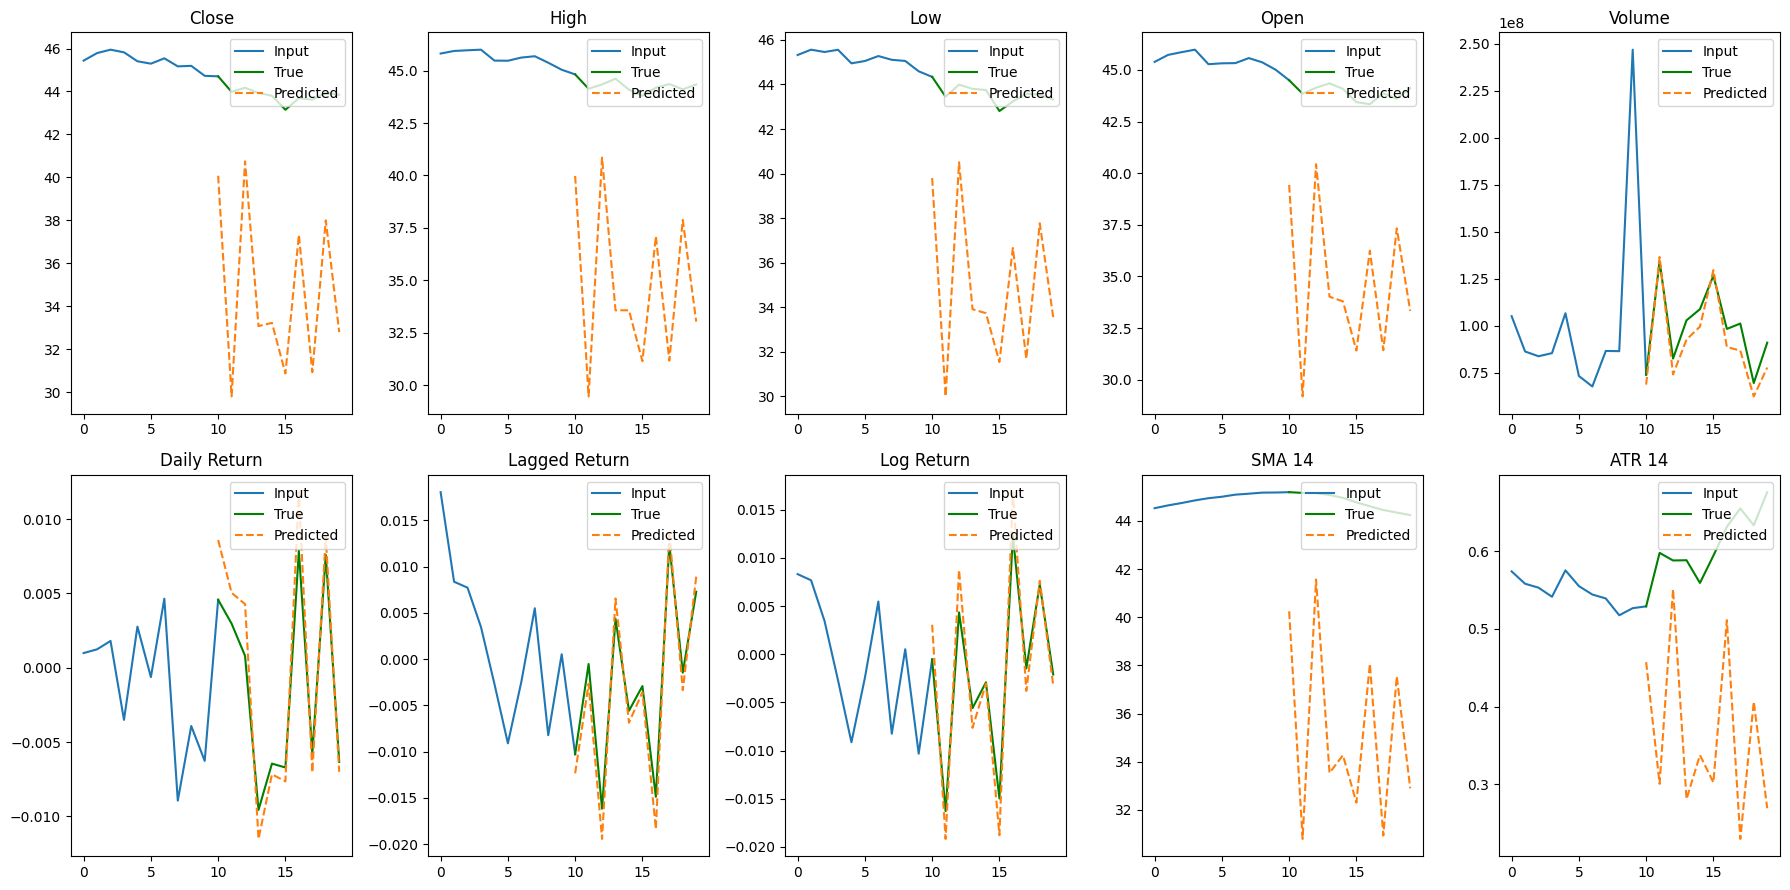

In [23]:
rand_idx = np.random.randint(0, len(X_train_seq))

x = X_train_seq[rand_idx].cpu().detach().numpy()
y_true = y_train_seq[rand_idx].cpu().detach().numpy()
y_pred = model(X_train_seq[rand_idx], y_train_seq[rand_idx]).cpu().detach().numpy()

x = scaler.inverse_transform(x)
y_true = scaler.inverse_transform(y_true)
y_pred = scaler.inverse_transform(y_pred)

fig, axes = plt.subplots(2, 5, figsize=(18, 9))
axes = axes.flatten()

for idx, c in enumerate(df.columns):

    input_seq = x[:, idx]
    true_seq = y_true[:, idx]
    pred_seq = y_pred[:, idx]

    axes[idx].plot(range(len(input_seq)+1), np.hstack((input_seq, true_seq[0])), label='Input', color='#1f77b4')
    axes[idx].plot(range(len(input_seq), len(input_seq) + len(true_seq)), true_seq, label='True', color='green')
    axes[idx].plot(range(len(input_seq), len(input_seq) + len(pred_seq)), pred_seq, label='Predicted', color='#ff7f0e', linestyle='dashed')

    axes[idx].set_title(c)
    axes[idx].legend(loc='upper right')

plt.tight_layout()
plt.show()

# Plot test results (one random sequence)

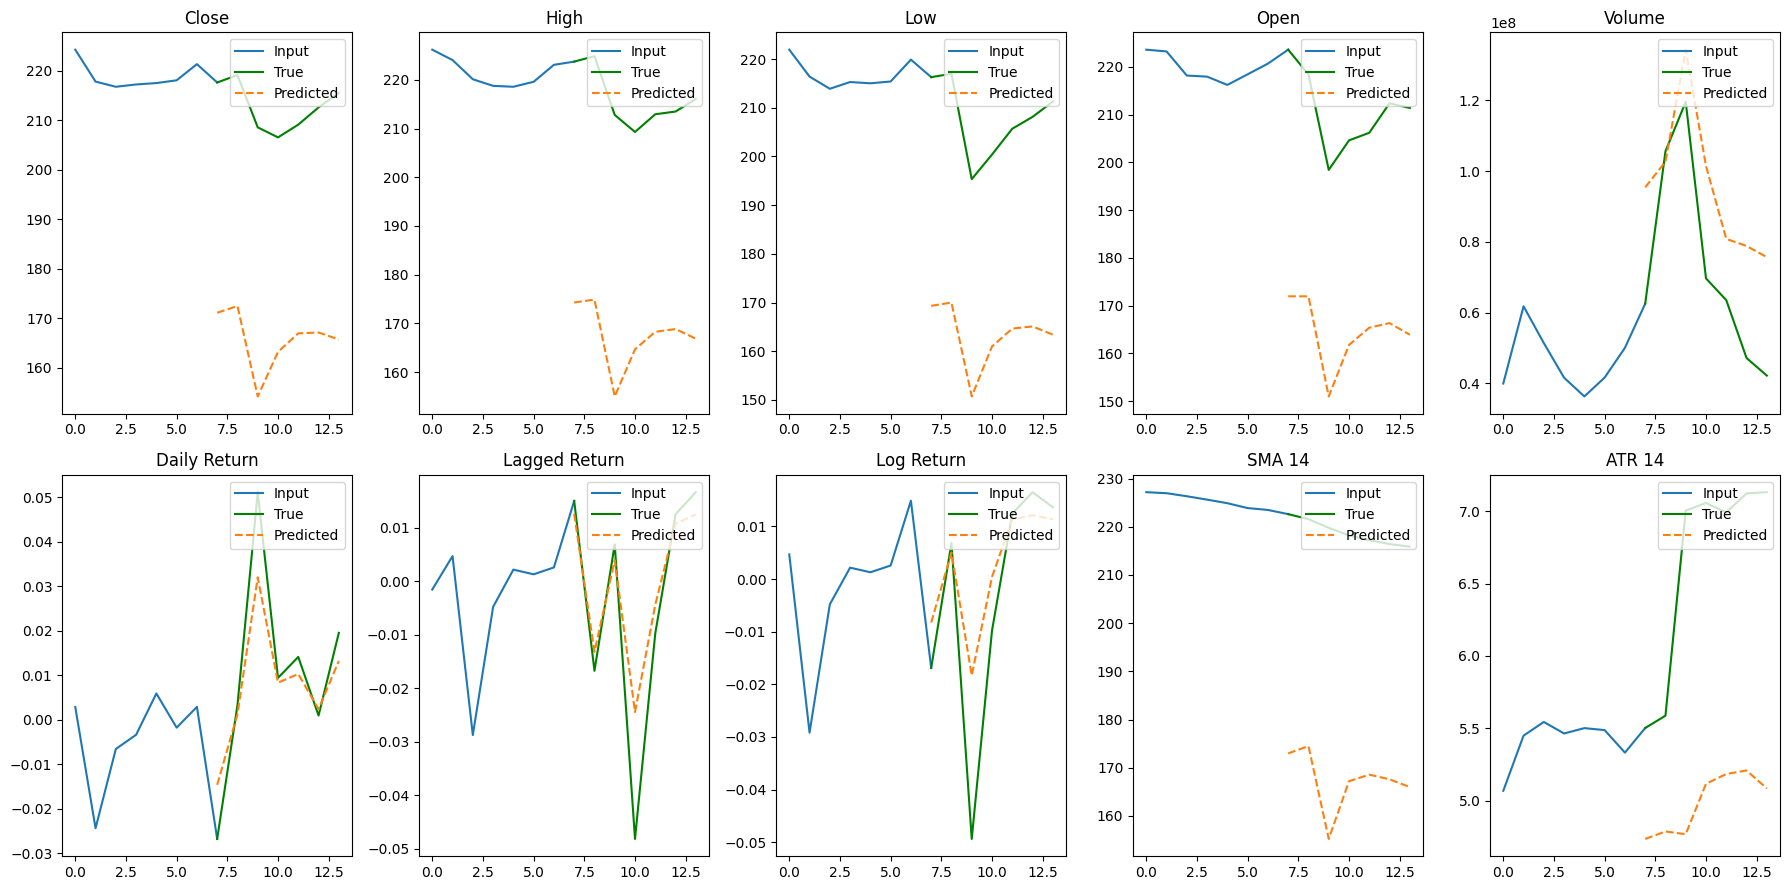

In [24]:
rand_idx = np.random.randint(0, len(X_test_seq))

x = X_test_seq[rand_idx].cpu().detach().numpy()
y_true = y_test_seq[rand_idx].cpu().detach().numpy()
y_pred = model(X_test_seq[rand_idx], y_test_seq[rand_idx]).cpu().detach().numpy()

x = scaler.inverse_transform(x)
y_true = scaler.inverse_transform(y_true)
y_pred = scaler.inverse_transform(y_pred)

fig, axes = plt.subplots(2, 5, figsize=(18, 9))
axes = axes.flatten()

for idx, c in enumerate(df.columns):

    input_seq = x[:, idx]
    true_seq = y_true[:, idx]
    pred_seq = y_pred[:, idx]

    axes[idx].plot(range(len(input_seq)+1), np.hstack((input_seq, true_seq[0])), label='Input', color='#1f77b4')
    axes[idx].plot(range(len(input_seq), len(input_seq) + len(true_seq)), true_seq, label='True', color='green')
    axes[idx].plot(range(len(input_seq), len(input_seq) + len(pred_seq)), pred_seq, label='Predicted', color='#ff7f0e', linestyle='dashed')

    axes[idx].set_title(c)
    axes[idx].legend(loc='upper right')

plt.tight_layout()
plt.show()